In [ ]:
# To test slideshow run this cell.  Use LiveReveal.js in class.

!jupyter nbconvert Lecture-18.ipynb --to slides --post serve

# Lecture 18: Numerical Solutions to the Diffusion Equation  
## (Implicit Methods)  

### Sections

* [Introduction](#Introduction)
* [Learning Goals](#Learning-Goals)
* [On Your Own](#On-Your-Own)
* [In Class](#In-Class)
    * [Revisiting the Discrete Version of Fick's Law](#Revisiting-the-Discrete-Version-of-Fick's-Law)
    * [A Linear System for Diffusion](#A-Linear-System-for-Diffusion)
    * [An Implicit Numerical Solution](#An-Implicit-Numerical-Solution)
    * [Deconstruction of the Solution Scheme](#Deconstruction-of-the-Solution-Scheme)
* [Homework](#Homework)
* [Summary](#Summary)
* [Looking Ahead](#Looking-Ahead)
* [Reading Assignments and Practice](#Reading-Assignments-and-Practice)

Possible future improvement:  Crank-Nicholson.

### Introduction
----

In this lecture I introduce you to the implicit scheme for solving the diffusion equation.  The equation and solution strategy are not particular to one another.  In my experience there are many implicit schemes that I've encountered.  They improve upon what I'm going to demonstrate in this lecture - by working through this example you will have the foundations.  The scheme is based on a linear algebra representation of the discrete form of Fick's law.

Different texts handle things differently - some do a better job of explaining boundary conditions, some a better job of the linear algebra.  I recommend starting with Numerical Recipes by Teukolsky, et al. to give you a foundation.

[Top of Page](#Sections)

### Learning Goals
----

* Re-develop the descretizaton of Fick's law such that the solution scheme is implicit
* Write the method as a linear system
* Incorporate boundary conditions
* Develop a solution strategy using linear algebra and Numpy or SciPy as appropriate.

[Top of Page](#Sections)

### On Your Own
----

Suggestions for improvement of this section:

* Develop numpy methods for linear algebra (e.g. creating matrices efficiently)
* Matrix operations relevant to LA.
* Solve a simple linear system.

[Top of Page](#Sections)

### In Class
----

* Re-derive the discrete form of Fick's law.
* Examine the structure of the resulting matrix.
* Write a solver.

### Revisiting the Discrete Version of Fick's Law

We start with a re-statement of Fick's second law in finite difference form that uses a FORWARD difference in time:

$
\frac{u_{i,\, j+1} - u_{i,\, j}}{\Delta t} = D \frac{u_{i - 1,\, j} - 2 u_{i,\, j} + u_{i + 1,\, j}}{\Delta x^2}
$

This choice of time differencing led to the EXPLICIT scheme.  This time, we choose a BACKWARD difference in time as follows:

$
\frac{u_{i,\, j} - u_{i,\, j-1}}{\Delta t} = D \frac{u_{i - 1,\, j} - 2 u_{i,\, j} + u_{i + 1,\, j}}{\Delta x^2}
$

This choice leads to a set of linear equations.  To illustrate how this develops we will write the equation above for a grid of six points that represent the quantity of diffusing substance.

Rearranging this differencing scheme, we can write down:

$$
u_{i,\, j-1} = \frac{\Delta t D}{\Delta x^2} \left( - u_{i - 1,\, j} + 2 u_{i,\, j} - u_{i + 1,\, j} \right) + u_{i,\, j}
$$

one additional re-arrangment (substitute $\beta$ for the factor containing the diffusion coefficient) and we get:

$$
- \beta u_{i - 1,\, j} + (1 + 2 \beta) u_{i,\, j} - \beta u_{i + 1,\, j} = u_{i,\, j-1}
$$

If we add "ghost cells" to the boundaries of our domain, it is a trivial matter (e.g. I stared at this for 3 hours to figure out what was going on) to write the equations in a matrix algebra form.  

I think it was helpful to algebraically write out the system of equations.  This helped me rationalize the boundary conditions effect on the matrix "M".

### A Linear System for Diffusion

In [5]:
%matplotlib inline

# This cell can be run from lecture.

import sympy as sp
sp.init_session(quiet=True)
var('U_LHS U_RHS')

IPython console for SymPy 1.0 (Python 2.7.6-64-bit) (ground types: python)


We define the symbols we want to use:

In [2]:
var('dt dx beta u1:7 b1:7')

In this cell we create the square matrix holding the coefficients that multiply the unknown quantities.  Note the structure of the matrix.  It is a _tridiagonal_ matrix.  I apologize for the syntax here, but the more compact version I can't explain properly.

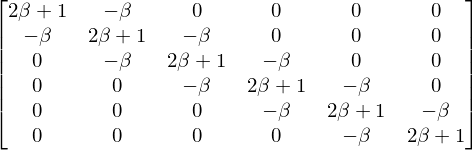

In [3]:
hpad = ones(0, 1); vpad = ones(1, 0)
mainDiag = 2*beta+1; offDiag = -beta

M = (sp.diag(vpad, offDiag, offDiag, offDiag, offDiag, offDiag, hpad)+ \
     sp.diag(hpad, offDiag, offDiag, offDiag, offDiag, offDiag, vpad)+ \
     sp.diag(mainDiag,mainDiag,mainDiag,mainDiag,mainDiag,mainDiag))

M

While moderately more efficient than typing the whole thing out, I think a nested `for` loop will be more transparent to the reader.

Here is our vector of unknown quantities.  I've dropped the time indices for now.  All of these symbols represent the value of our field (e.g. concentration, temperature, etc.) at the next time step.

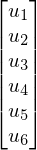

In [4]:
xmatrix = sp.Matrix([u1,u2,u3,u4,u5,u6])
xmatrix

If we've got everything correct, this matrix product will reproduce the discrete diffusion equation outlined above.  You'll note that the boundary equations are not formed correctly.  For reference, here is the discrete form:

$$
- \beta u_{i - 1,\, j} + (1 + 2 \beta) u_{i,\, j} - \beta u_{i + 1,\, j} = u_{i,\, j-1}
$$

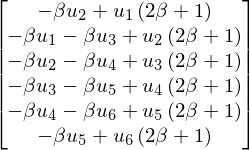

In [5]:
M*xmatrix

It should start to become clear that we can write this linear system (of a tridiagonal matrix and a column vector of unknowns) as a matrix equation:

$$
M \cdot x = b
$$

Where M is the square matrix, x is the vector of unknown quantities and b is the last known value of the system variables.  There is still some work to be done before we can use linear algebra to get the solution.  We need to implement the boundary conditions.

$$
- \beta u_{i - 1,\, j} + (1 + 2 \beta) u_{i,\, j} - \beta u_{i + 1,\, j} = u_{i,\, j-1}
$$

To get the form correct at the top and bottom of this solution vector we need to imagine adding "ghost cells" to the boundaries of our domain at $i=0$ and $i=7$.  Using this expression, let $i = 1$:

$$
- \beta u_{0,\, j} + (1 + 2 \beta) u_{1,\, j} - \beta u_{2,\, j} = u_{1,\, j-1}
$$

If we have fixed value boundary conditions, we know the value of $u_0$.  This is the boundary condition of our simulation.  We will call this value $U_{LHS}$, substitute $U_{LHS} = u_0$ and move the known quantities to the RHS of the equation:

$$
(1 + 2 \beta) u_{1,\, j} - \beta u_{2,\, j} = u_{1,\, j-1} + \beta U_{LHS, \,j}
$$

_Note:  Section being written.  Reader should skip for now._

If we have fixed flux boundary conditions we can write the flux as a central difference on the cell $u_1$ that uses the "ghost" point at $u_0$:

$$
\frac{u_{2,\, j} - u_{0,\, j}}{2 \Delta x} = F
$$

Proceeding as before with $i=1$:

$$
- \beta u_{0,\, j} + (1 + 2 \beta) u_{1,\, j} - \beta u_{2,\, j} = u_{1,\, j-1}
$$

This time we know the relationship of $u_0$ to the other unknowns due to the specification of the defined flux boundary condition.  Solving for $u_0$ we get:

$$
u_{0,\, j} = u_{2,\, j} - {2 \Delta x} F
$$

Substituting this into our expression that includes the ghost cell gives us:


$$
- \beta (u_{2,\, j} - {2 \Delta x} F) + (1 + 2 \beta) u_{1,\, j} - \beta u_{2,\, j} = u_{1,\, j-1}
$$

Simplifying:

$$
(1 + 2 \beta) u_{1,\, j} - 2 \beta u_{2,\, j} = u_{1,\, j-1} - \beta 2 \Delta x F 
$$

So in this case we have to modify the matrix $M$ entries AND the solution vector $b$ recalling that the $j-1$ index is the known solution.

We have now recovered the form of the equation in the dot product $M \cdot x$ and the form of this equation is telling us that we need to modify the solution vector $b$ with information about the boundary conditions before we find the inverse of the matrix and compute the new solution vector.

Modifying the $b$ matrix with the known ghost cell values we get:

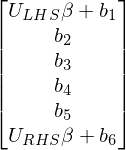

In [6]:
wha = b1+beta*U_LHS
bmatrix = sp.Matrix([(b1+beta*U_LHS),b2,b3,b4,b5,(b6+beta*U_RHS)]) 
bmatrix

So the full form of our system is therefore:

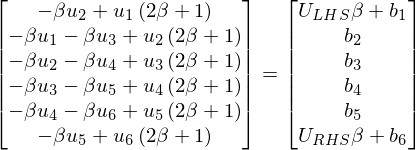

In [7]:
sp.Eq(M*xmatrix,bmatrix)

At this point you could try and implement "no flux" or "fixed flux" boundary conditions.  If you write the condition as a central difference on points $u_1$ and $u_6$ above - the ghost cells well identify how to modify $b_1$ and $b_6$ as well as two of the matrix entries in $M_{i,j}$.  I dread writing it (and I'm sorry to say it), but this is left as an exercise to the reader!

With this understanding, we are now ready to solve the system.

[Top of Page](#Sections)

### An Implicit Numerical Solution

General setup in this section:

In [9]:
# Run this cell before lecture

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Simulation parameters:

In [36]:
numberOfPoints = 100
lengthOfDomain = 1.0
dx = lengthOfDomain/numberOfPoints
xPoints = np.linspace(0.0, lengthOfDomain, numberOfPoints)
initialCondition = np.sin(xPoints*np.pi/lengthOfDomain)

A simple function to plot the initial condition:

In [11]:
def plotIC():
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    axes.plot(xPoints, initialCondition, 'ro')
    axes.set_xlabel('Distance $x$')
    axes.set_ylabel('Concentration of Stuff $c(x,t)$')
    axes.set_title('Initial Conditions');

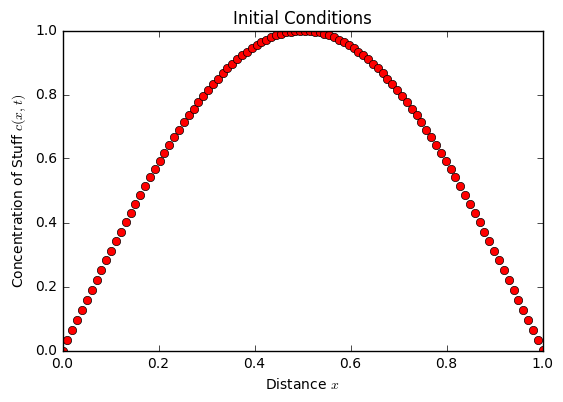

In [12]:
plotIC()

It is worth noting that these schemes are unconditionally stable - so any choice of time step will produce a solution.  The accuracy of the solution does depend on this choice, though.

In [13]:
diffusionCoefficient = 10.0
dt = dx**2/(diffusionCoefficient)
numberOfIterations = 1000

We create two solution vectors rather than one whole array to hold all of our solution.  This is not particular to the implicit method, but it demonstrates another technique for saving memory and speeding up the calculation.  We will fill these matrices and swap them (move data from `new` into `old` and overwrite `new`) at each time step.

In [14]:
newConcentration = np.zeros((numberOfPoints), dtype='float32')
oldConcentration = np.zeros((numberOfPoints), dtype='float32')

First, some syntax:

In [18]:
['h','h','h']*3

['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h']

The matrix has to be square.  It should have the same dimensions as the nubmer of points in the system.  The following code snippet was inspired by [this](http://stackoverflow.com/questions/5842903/block-tridiagonal-matrix-python) post.

In [57]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

a = [-dt*diffusionCoefficient/dx/dx]*(numberOfPoints-1)
b = [2*dt*diffusionCoefficient/dx/dx+1]*(numberOfPoints)
c = [-dt*diffusionCoefficient/dx/dx]*(numberOfPoints-1)

A = tridiag(a, b, c)

In [58]:
#A[0,1] = -2
#A[-1,-2] = -2

In [59]:
A

array([[ 3., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  3., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  3., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  3., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  3., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  3.]])

We first need to prime the arrays by copying the initial condition into `oldConcentration`.  Afterwards it will be enough to swap pointers (a variable that points to a memory location).

In [40]:
np.copyto(oldConcentration,initialCondition)

[Top of Page](#Sections)

### Deconstruction of the Solution Scheme

In spite of the small chunk of code a few cells below, there is a lot going on.  Let us dissect it.  In bullet points:

* Before the first solution step we enforce the boundary conditions.  Our choice of matrix means that we are using "fixed value" boundary conditions.  So we need to modify the `b` vector accordingly.

```python
    oldConcentration[0] = oldConcentration[0] + uLHS*dt*diffusionCoefficient/dx/dx
    oldConcentration[-1] = oldConcentration[-1] + uRHS*dt*diffusionCoefficient/dx/dx

```

Recall:

$$
\left[\begin{matrix}- \beta u_{2} + u_{1} \left(2 \beta + 1\right)\\- \beta u_{1} - \beta u_{3} + u_{2} \left(2 \beta + 1\right)\\- \beta u_{2} - \beta u_{4} + u_{3} \left(2 \beta + 1\right)\\- \beta u_{3} - \beta u_{5} + u_{4} \left(2 \beta + 1\right)\\- \beta u_{4} - \beta u_{6} + u_{5} \left(2 \beta + 1\right)\\- \beta u_{5} + u_{6} \left(2 \beta + 1\right)\end{matrix}\right] = \left[\begin{matrix}U_{LHS} \beta + b_{1}\\b_{2}\\b_{3}\\b_{4}\\b_{5}\\U_{RHS} \beta + b_{6}\end{matrix}\right]
$$

* Solving the system involves using the built in `NumPy` functions to invert the matrix.  What is returned is the solution vector.  Please note that I'm using an internal `Numpy` (an optimized function!) function to COPY the results of the linear algebra solution into the `newConcentration` vector. 

```python
    np.copyto(newConcentration,np.linalg.solve(A,oldConcentration))
```

* Tuple unpacking in Python leads to the `A,B=B,A` syntax below.  This switches the references to the arrays.  This is important for efficiency - you don't want to move any data if you don't have to.  If you are running big calculations then moving that data around is a waste of time/resources.  Better to just swap references.

```python
    oldConcentration, newConcentration = newConcentration, oldConcentration
```

* Repeat the process and after a specified number of iterations, plot the results.

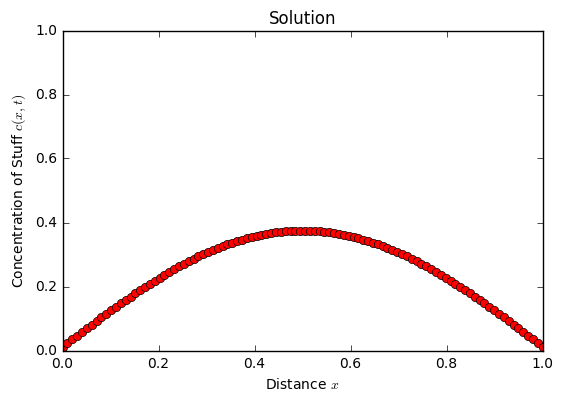

In [63]:
uLHS = 0.0
uRHS = 0.0
numIterations = 200

for i in range(numIterations):
    # enforce boundary conditions
    oldConcentration[0] = oldConcentration[0] + uLHS*dt*diffusionCoefficient/dx/dx
    oldConcentration[-1] = oldConcentration[-1] + uRHS*dt*diffusionCoefficient/dx/dx
    # solve the system
    np.copyto(newConcentration,np.linalg.solve(A,oldConcentration))
    # swap pointers
    oldConcentration, newConcentration = newConcentration, oldConcentration

# plot the results
fig2 = plt.figure()
axes = fig2.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(xPoints, newConcentration, 'ro')
axes.set_ylim(0,1)
axes.set_xlabel('Distance $x$')
axes.set_ylabel('Concentration of Stuff $c(x,t)$')
axes.set_title('Solution');

[Top of Page](#Sections)

### Homework
----

* Solve the diffusion couple problem
* Compare to the analytical solution
* Describe the differences between them (in words and with some plots, maybe)
* Examine the error in terms of truncation versus roundoff error.

[Top of Page](#Sections)

### Looking Ahead
----

TBA

[Top of Page](#Sections)

### Reading Assignments and Practice
----

TBA

[Top of Page](#Sections)